In [ ]:
import torch

# import seaborn as sns

from nll_to_po.models.dn_policy import MLPPolicy
from nll_to_po.training.utils import train_single_policy
import nll_to_po.training.loss as L

# sns.set_theme(style="whitegrid", font_scale=1.5)
# sns.set_palette("colorblind")
# sns.despine()

import wandb as wb

In [ ]:
# Experiment parameters
n_experiments = 10  # Number of repetitions
n_updates = 200
input_dim = 4
output_dim = 2
hidden_sizes = [64, 64]

fixed_logstd = False
init_dist_loc = 1.0
init_dist_scale = 0.1
init_dist_n_samples = 25
rsample_for_grpo = False

learning_rate = 0.001

for _ in range(n_experiments):
    policy = MLPPolicy(input_dim, output_dim, hidden_sizes, fixed_logstd)

    # Generate new random data for each experiment
    X = torch.randn(1, input_dim)
    mean_y = 2 + torch.randn(1, output_dim) * init_dist_loc
    y = mean_y + torch.randn(init_dist_n_samples, output_dim) * init_dist_scale
    X = X.repeat(init_dist_n_samples, 1)  # Repeat X for each sample

    # Create a DataLoader
    train_dataset = torch.utils.data.TensorDataset(X, y)
    train_dataloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=1, shuffle=True
    )

    # Define the loss function
    loss_function = L.NLL()
    # loss_function = L.PO(
    #     n_generations=100,
    #     use_rsample=False,
    #     reward_transform="normalize",  # "normalize", "rbf", "none"
    #     rbf_gamma=None,
    # )

    wandb_run = wb.init(
        project="mse_nll_po",
        name="NLL",
        config={
            "fixed_logstd": fixed_logstd,
            "init_dist_loc": init_dist_loc,
            "loss": "NLL",
            "learning_rate": learning_rate,
            # "n_generations": 100,
            # "reward_transform": "normalize",
            "init_dist_n_samples": init_dist_n_samples,
        },
    )

    # Run comparison
    train_single_policy(
        policy=policy,
        train_dataloader=train_dataloader,
        loss_function=loss_function,
        n_updates=n_updates,
        learning_rate=learning_rate,
        wandb_run=wandb_run,
    )

    wandb_run.finish()

In [ ]:
# Experiment parameters
n_experiments = 10  # Number of repetitions
n_updates = 200
input_dim = 4
output_dim = 2
hidden_sizes = [64, 64]

fixed_logstd = False
init_dist_scale = 0.1
rsample_for_grpo = False

learning_rate = 0.001

for init_dist_n_samples in [1, 25]:
    for init_dist_loc in [1.0, 7.0]:
        for rbf_gamma in [0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 100.0]:
            for n_gen in [1, 2, 5, 10, 25, 50, 100]:
                for _ in range(n_experiments):
                    policy = MLPPolicy(
                        input_dim, output_dim, hidden_sizes, fixed_logstd
                    )

                    # Generate new random data for each experiment
                    X = torch.randn(1, input_dim)
                    mean_y = 2 + torch.randn(1, output_dim) * init_dist_loc
                    y = (
                        mean_y
                        + torch.randn(init_dist_n_samples, output_dim) * init_dist_scale
                    )
                    X = X.repeat(init_dist_n_samples, 1)  # Repeat X for each sample

                    # Create a DataLoader
                    train_dataset = torch.utils.data.TensorDataset(X, y)
                    train_dataloader = torch.utils.data.DataLoader(
                        train_dataset, batch_size=1, shuffle=True
                    )

                    # Define the loss function
                    # loss_function = L.NLL()
                    loss_function = L.PO(
                        n_generations=n_gen,
                        use_rsample=False,
                        reward_transform="rbf",  # "normalize", "rbf", "none"
                        rbf_gamma=rbf_gamma,
                    )

                    wandb_run = wb.init(
                        project="ablation_po_rbf",
                        name=f"PO_gamma={rbf_gamma}",
                        config={
                            "fixed_logstd": fixed_logstd,
                            "init_dist_loc": init_dist_loc,
                            "loss": f"PO_gamma={rbf_gamma}",
                            "learning_rate": learning_rate,
                            "n_generations": n_gen,
                            "reward_transform": "rbf",
                            "init_dist_n_samples": init_dist_n_samples,
                            "rbf_gamma": rbf_gamma,
                        },
                    )

                    # Run comparison
                    train_single_policy(
                        policy=policy,
                        train_dataloader=train_dataloader,
                        loss_function=loss_function,
                        n_updates=n_updates,
                        learning_rate=learning_rate,
                        wandb_run=wandb_run,
                    )

                    wandb_run.finish()

In [ ]:
import numpy as np

import matplotlib.pyplot as plt


# Define the RBF kernel function
def rbf_kernel(x, gamma):
    return np.exp(-gamma * x**2)


# Create x values
x = np.linspace(-3, 3, 1000)

# Define different gamma values
gamma_values = [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]

# Create the plot
plt.figure(figsize=(10, 6))

for gamma in gamma_values:
    y_rbf = rbf_kernel(x, gamma)
    plt.plot(x, y_rbf, label=f"γ = {gamma}", linewidth=2)

plt.xlabel("x")
plt.ylabel("RBF Kernel Value")
plt.title("RBF Kernel with Different Gamma Values")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(-3, 3)
plt.ylim(0, 1.1)
plt.show()

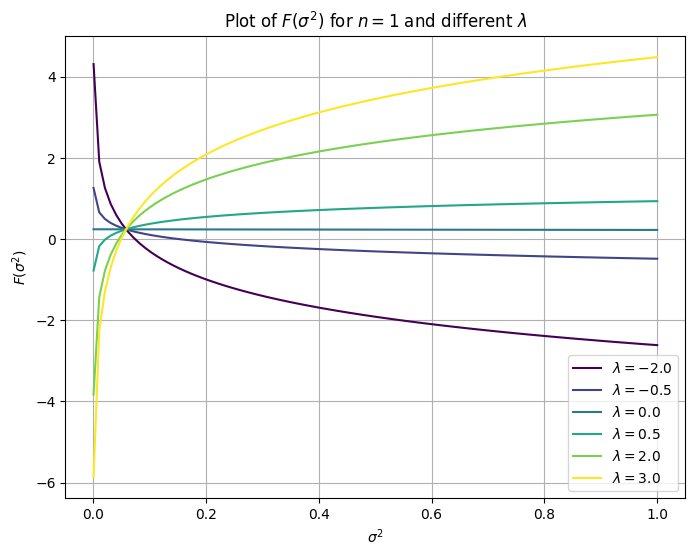

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
n = 1
omega = 0.75  # strictly positive
beta = 2.5  # strictly positive
mu = 1.0
alpha = 1.0


# Define the function for F(sigma^2) with lambda
def F(sigma2, lam):
    A = omega + 2 * sigma2 + 2 * beta**2
    C = (alpha - mu) ** 2
    term1 = (omega / A) ** (n / 2) * np.exp(-C / A)
    term2 = (lam * n / 2) * np.log(2 * np.pi * np.e * sigma2)
    return term1 + term2


# Range for sigma^2 (avoid 0 exactly)
sigma2_vals = np.linspace(1e-3, 1, 100)

# Different lambda values to compare
lambda_values = [-2.0, -0.5, 0.0, 0.5, 2.0, 3.0]
colors = plt.cm.viridis(np.linspace(0, 1, len(lambda_values)))

# Plot
plt.figure(figsize=(8, 6))
for lam, col in zip(lambda_values, colors):
    F_vals = F(sigma2_vals, lam)
    plt.plot(sigma2_vals, F_vals, label=rf"$\lambda={lam}$", color=col)

plt.xlabel(r"$\sigma^2$")
plt.ylabel(r"$F(\sigma^2)$")
plt.title(r"Plot of $F(\sigma^2)$ for $n=1$ and different $\lambda$")
plt.grid(True)
plt.legend()
plt.show()

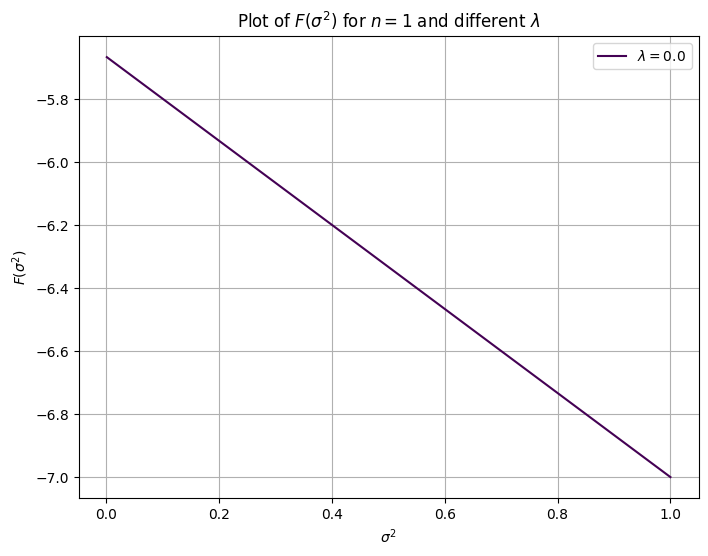

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
n = 1
omega = 0.75  # strictly positive
beta = 2.5  # strictly positive
mu = 1.0
alpha = 1.0


# Define the function for F(sigma^2) with lambda
def G(sigma2, lam):
    term1 = (2 / omega) * np.array(mu).dot(np.array(alpha)) - (n / omega) * (
        sigma2 + beta**2
    )
    term2 = (lam * n / 2) * np.log(2 * np.pi * np.e * sigma2)
    return term1 + term2


# Range for sigma^2 (avoid 0 exactly)
sigma2_vals = np.linspace(1e-3, 1, 100)

# Different lambda values to compare
lambda_values = [0.0]  # [-2.0, -0.5, 0.0, 0.5, 2.0, 3.0]
colors = plt.cm.viridis(np.linspace(0, 1, len(lambda_values)))

# Plot
plt.figure(figsize=(8, 6))
for lam, col in zip(lambda_values, colors):
    F_vals = G(sigma2_vals, lam)
    plt.plot(sigma2_vals, F_vals, label=rf"$\lambda={lam}$", color=col)

plt.xlabel(r"$\sigma^2$")
plt.ylabel(r"$F(\sigma^2)$")
plt.title(r"Plot of $F(\sigma^2)$ for $n=1$ and different $\lambda$")
plt.grid(True)
plt.legend()
plt.show()